# Проект: поведение пользователей мобильного приложения

Цель проекта: определить, повлияет ли изменение шрифта в приложении на поведение пользователей.  

Задачи:  
- изучить данные и определить период анализа;
- узнать, какие события входят в логи, и их частоту;
- построить воронку событий и определить, на каком шаге теряется больше всего пользователей;
- проверить, есть ли статистические различия между контрольными группами и группой с изменённым шрифтом.

## Описание данных

Каждая запись в логе — это действие пользователя, или событие.   
*EventName* — название события;  
*DeviceIDHash* — уникальный идентификатор пользователя;  
*EventTimestamp* — время события;  
*ExpId* — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Загрузка данных

In [1]:
#загружаем нужные библиотеки
import pandas as pd
from datetime import datetime, timedelta 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats as st
import numpy as np
import math as mth
from plotly import graph_objects as go

In [2]:
#загружаем данные
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
    
except:
    df =  pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Предобработка данных

In [5]:
# переименовываем переменные
df.columns=['event_name', 'device_id', 'event_timestamp', 'group']

In [6]:
df.head()

,event_name,device_id,event_timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [7]:
# ищем пропуски
display(df.isna().sum())

#ищем дубликаты 
print('Количество дубликатов:', df.duplicated().sum())

event_name         0
device_id          0
event_timestamp    0
group              0
dtype: int64

Количество дубликатов: 413


In [8]:
# процент дубликтов от общего датасета
round(df.duplicated().sum()/len(df)*100, 2)

0.17

В датасете 413 дубликатов, так как они составляют всего 0,17% от данных, мы можем их удалить.

In [9]:
# удаляем дубликаты 
df = df.drop_duplicates()

In [10]:
# добавляем столбец даты и времени, а также отдельный столбец дат
df['datetime'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['date'] = df['datetime'].dt.date
df['date']=pd.to_datetime(df['date'])

In [11]:
df.head()

,event_name,device_id,event_timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


## Изучение данных

In [12]:
# Сколько всего событий в логе
print('Количество событий:', len(df))
print('Количество уникальных событий:', df['event_name'].nunique())

Количество событий: 243713
Количество уникальных событий: 5


In [13]:
# какие события происходят чаще
events = df.groupby('event_name').agg({'device_id':'count'}).sort_values(by='device_id', ascending=False)
events.columns=['events_amount']
display(events)

,events_amount
event_name,
MainScreenAppear,119101
OffersScreenAppear,46808
CartScreenAppear,42668
PaymentScreenSuccessful,34118
Tutorial,1018


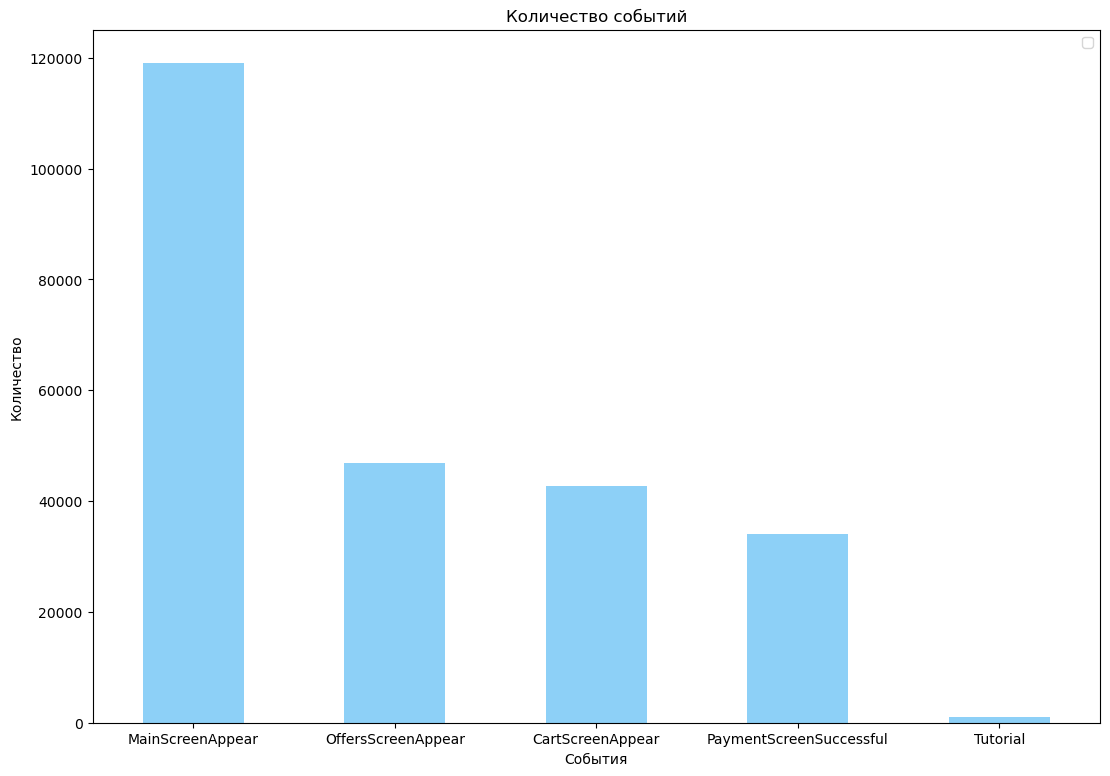

In [14]:
# визуализируем количество событий 
plt.rcParams['figure.figsize'] = [13, 9] #корректируем размер графика
events.plot(kind='bar', color='#8dd0f7')
plt.legend('')
plt.title('Количество событий')
plt.xlabel('События')
plt.ylabel('Количество')
plt.xticks(rotation=0);

Самое популярное событие - просмотр главной страницы. А вот туториалы оказались непопулярными - их посмотрели чуть больше тысячи раз.

In [15]:
#Сколько всего пользователей в логе
print('Количество уникальных пользователей:', df['device_id'].nunique())

#Сколько пользователей в каждой группе
print('Количество пользователей по группам')
user_groups=df.groupby('group')['device_id'].nunique()
display(user_groups)

Количество уникальных пользователей: 7551
Количество пользователей по группам


group
246    2489
247    2520
248    2542
Name: device_id, dtype: int64

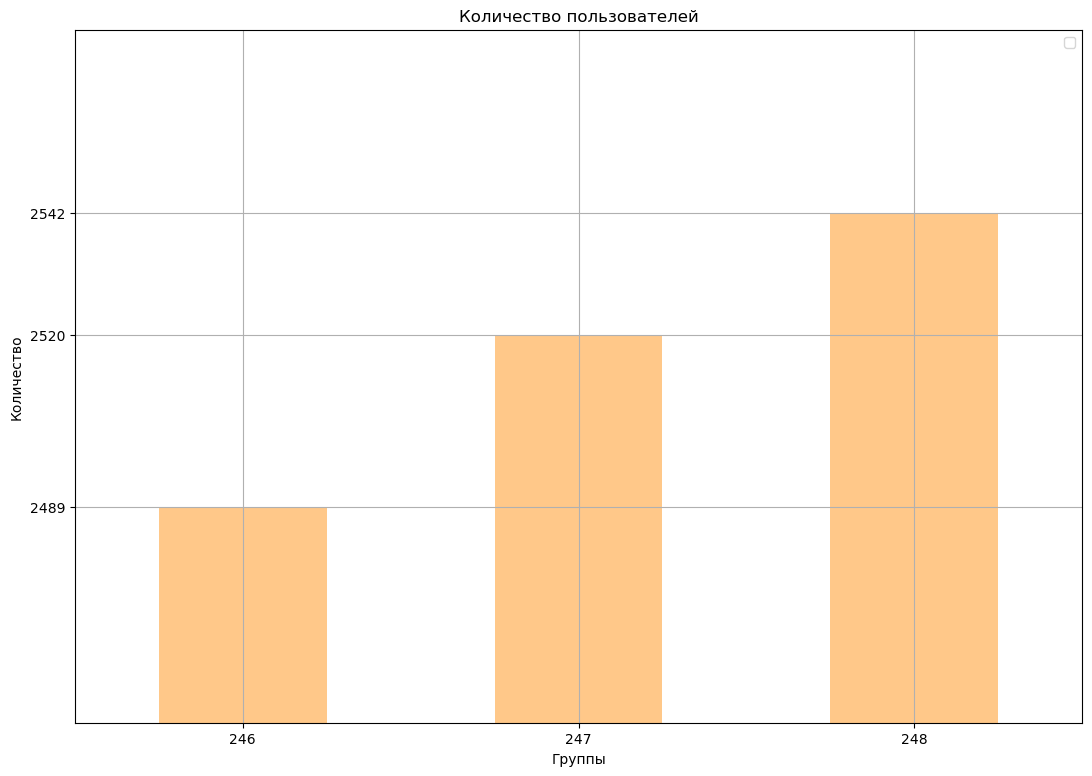

In [16]:
# визуализируем количество пользователей по группам 
plt.rcParams['figure.figsize'] = [13, 9] #корректируем размер графика
user_groups.plot(kind='bar', color='#FFC889', ylim=([2450, 2575]), grid=True) # заодно задаем диапазон оси y
plt.legend('')
plt.title('Количество пользователей')
plt.xlabel('Группы')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.yticks(user_groups); # делаем подписи по точному количеству пользователей

В 248 (экспериментальной) группе больше всего пользователей, в контрольных 246 и 247 - меньше.

In [17]:
#Сколько в среднем событий приходится на пользователя
events_per_user = df.pivot_table(index='device_id',values='event_name',aggfunc='count')['event_name'].mean()
print('Среднее количество событий на пользователя:', round(events_per_user))

Среднее количество событий на пользователя: 32


In [18]:
# период данных
print('Минимальная дата:', df['date'].min())
print('Максимальная дата', df['date'].max())

Минимальная дата: 2019-07-25 00:00:00
Максимальная дата 2019-08-07 00:00:00


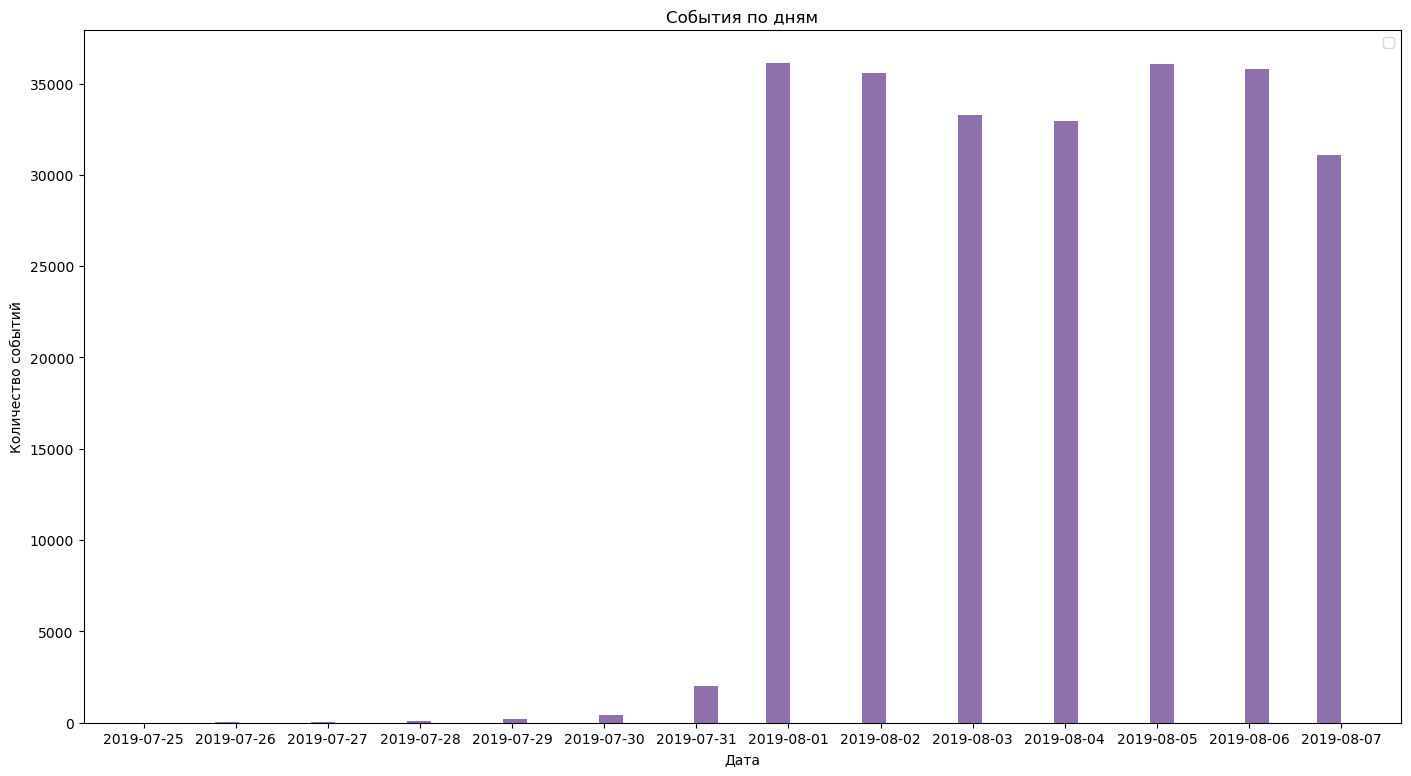

In [19]:
from matplotlib.dates import HourLocator, DayLocator, DateFormatter

# гистограмма дат
plt.rcParams['figure.figsize'] = [17,9]
df['date'].hist(bins=50, grid=False, color='#8e70ab')
plt.legend('')
plt.title('События по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=0)
days = DayLocator(interval=1) # указываем интервал (1 день) для засечек на оси х
plt.gca().xaxis.set_major_locator(days) # применяем интервал

На графике мы четко видим, что за период с 25 июля по 31 июля 2019 у нас слишком мало данных, так как в логи новых дней по некоторым пользователям попали события из прошлого. Для анализа мы возьмем данные начиная с 1 августа 2019.

In [20]:
# делаем срез
filtered_data = df.query('date > "2019-07-31"')
filtered_data.head()

,event_name,device_id,event_timestamp,group,datetime,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [21]:
# сколько дней в отфильтрованных данных
filtered_data['date'].max()-filtered_data['date'].min()

Timedelta('6 days 00:00:00')

In [22]:
# сколько потеряли событий и пользователей 

# сколько событий осталось после фильтрации
print('Количество событий до фильтрации:', len(df))
print('Количество событий после фильтрации:', len(filtered_data))
print('Процент событий потерян:', round((len(df)-len(filtered_data))/len(df)*100, 2))

Количество событий до фильтрации: 243713
Количество событий после фильтрации: 240887
Процент событий потерян: 1.16


In [23]:
#Сколько пользователей осталось после фильтрации
print('Количество уникальных пользователей до фильтрации:', df['device_id'].nunique())
print('Количество уникальных пользователей после фильтрации:', filtered_data['device_id'].nunique())
print('Процент пользователей потерян:', round((df['device_id'].nunique()-filtered_data['device_id'].nunique())/df['device_id'].nunique()*100, 2))

Количество уникальных пользователей до фильтрации: 7551
Количество уникальных пользователей после фильтрации: 7534
Процент пользователей потерян: 0.23


In [24]:
#Сколько пользователей в каждой группе
print('Количество пользователей по группам после фильтрации')
user_groups_filtered=filtered_data.groupby('group')['device_id'].nunique()
display(user_groups_filtered)

Количество пользователей по группам после фильтрации


group
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

In [25]:
# пользователей потеряно по группам
user_groups - user_groups_filtered

group
246    5
247    7
248    5
Name: device_id, dtype: int64

После фильтрации мы потеряли 1,16% событий и всего 0,23% пользователей. Это совсем незначительное количество.

## Воронка событий

Ранее мы увидели, какие события встречаются чаще: просмотр главной страницы - самое частое событие с большим отрывом. Далее следуют просмотр страницы с предложениями, корзина и страница оплаты. Очень редко пользователи смотрят туториалы.

In [26]:
events_frequency=filtered_data.groupby('event_name').agg({'device_id':'count'}).sort_values(by='device_id', ascending=False)
events_frequency.columns=['events_amount']
display(events)

,events_amount
event_name,
MainScreenAppear,119101
OffersScreenAppear,46808
CartScreenAppear,42668
PaymentScreenSuccessful,34118
Tutorial,1018


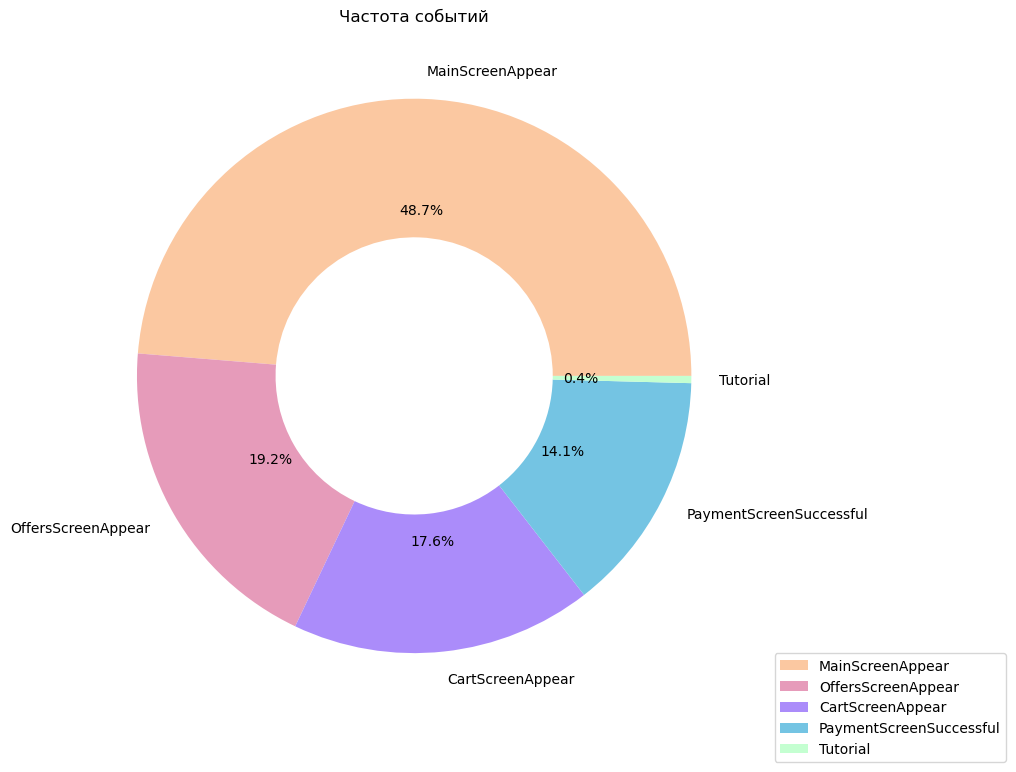

In [27]:
# частота событий
plt.rcParams['figure.figsize'] = [13, 9] #корректируем размер графика
events_frequency.plot(kind='pie', subplots=True,  wedgeprops=dict(width=0.5), autopct='%1.1f%%', colors = ['#FBC8A1', '#E69BBA', '#AB8CFA', '#74C4E3', '#C4FFD1'])
plt.legend('')
plt.title('Частота событий')
plt.xlabel('')
plt.ylabel('')
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0); #выносим легенду за пределы графика

Посмотрим, сколько пользователей совершали каждое из этих событий.

In [28]:
users_per_event=filtered_data.groupby('event_name').agg({'device_id':'nunique'}).sort_values(by='device_id', ascending=False)
users_per_event.columns=['users_amount']
display(users_per_event)

,users_amount
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [29]:
# сколько всего пользователей совершали события
users_total=len(filtered_data['device_id'].unique())
# добавляем столбец с процентом пользователей, совершивших событие
users_per_event['users_share']=round(users_per_event['users_amount']/users_total*100, 2)

In [30]:
users_per_event

,users_amount,users_share
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


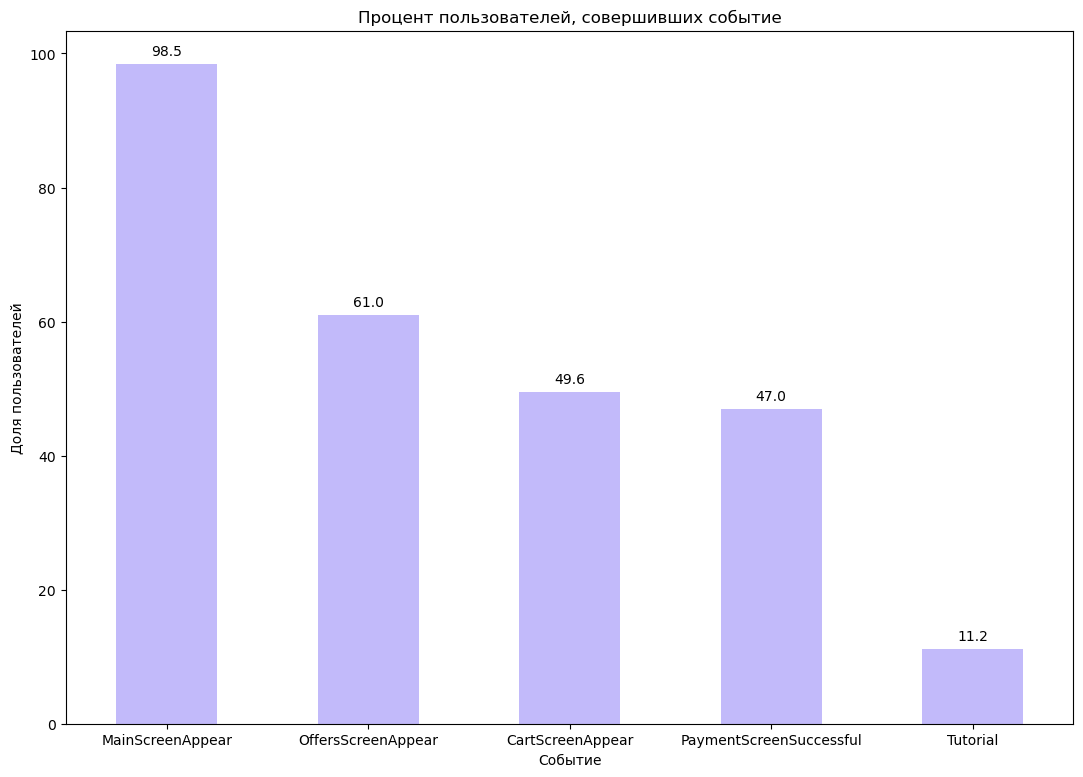

In [31]:
# визуализируем
plt.rcParams['figure.figsize'] = [13, 9]
splot=users_per_event['users_share'].sort_values(ascending=False).plot(kind='bar', color='#C2BAFA')


#добавляем подписи(проценты) на столбцах
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.title('Процент пользователей, совершивших событие')
plt.xlabel('Событие')
plt.ylabel('Доля пользователей')
plt.xticks(rotation=0);

Главный экран видят 98,5% пользователей. Возможно, у оставшихся 1,5% возникает ошибка в приложении, и они не могут его запустить. Воронка событий выглядит так: главный экран > страница с предложениями > корзина > оплата покупки. В воронку не входит страница с туториалами, для покупки она не обязательна. Далее мы посмотрим, какая доля пользователей проходит на каждый следующий шаг воронки.

In [32]:
users_per_event=users_per_event.reset_index()

# копируем таблицу и удаляем туториалы
funnel = users_per_event
funnel.drop([4], axis=0, inplace=True)

In [33]:
funnel

,event_name,users_amount,users_share
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


In [34]:
# считаем конверсию в шаг
funnel['step_share'] = 100
for i in range(1, 4):
    funnel.loc[i, 'step_share'] = funnel.loc[i, 'users_amount'] / (funnel.loc[i-1, 'users_amount']) *100

funnel['step_share']=round(funnel['step_share'], 2)

In [35]:
funnel

,event_name,users_amount,users_share,step_share
0,MainScreenAppear,7419,98.47,100.00
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


*users_amount* - количество пользователей, совершивших событие *event_name*  
*users_share* - доля пользователей, совершивших событие на первом шаге  
*step_share* -  доля пользователей к числу посетителей на предыдущем шаге  

С главного экрана на страницу предложений переходят чуть меньше 62%. На этом шаге теряется больше всего пользователей. 
Из пользователей, побывавших на странице предложений, в корзину переходят 81%. Возможно, остальных покупателей не заинтересовал ассортимент товаров.  
Оплату успешно завершают почти 95% добавивших товар в корзину. Мы можем предположить, что либо возникает проблема при оплате, либо пользователи не оформляют заказ, просто оставив товары в корзине. От первого события (т.е. просмотра главного экрана) до завершения оплаты доходят около 47% пользователей.

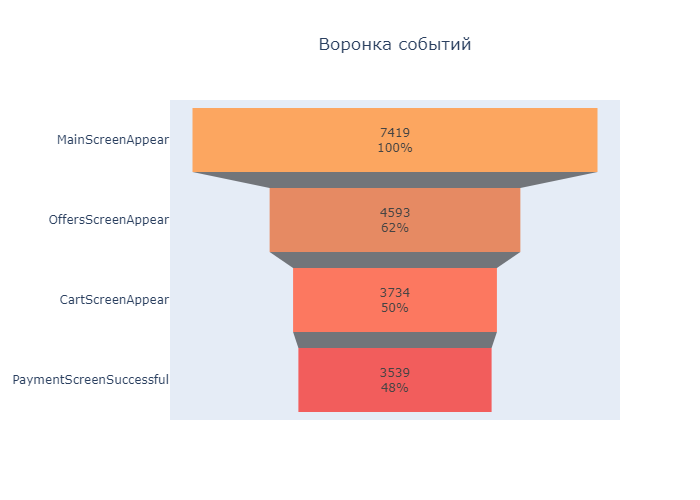

In [52]:
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['users_amount'],
    textposition = "inside",
    textinfo = "value+percent initial",
    marker = {"color": ['#FCA660', '#E68A63', '#FC7860', '#F25D5C']}
))
fig.update_layout(title='Воронка событий', title_xref="paper", title_x=0.5)
fig.show(renderer='png')

## Результаты A/A/B эксперимента

In [37]:
# сколько пользователей в каждой экспериментальной группе
users_by_group=filtered_data.groupby('group')['device_id'].nunique()
display(users_by_group)

group
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

In [38]:
# количество пользователей, совершивших событие в воронке, по группам
group_event=filtered_data.pivot_table(index='event_name', columns='group', values='device_id', aggfunc='nunique').sort_values(by='event_name', ascending=False)
group_event=group_event.query('event_name != "Tutorial" ')
group_event

group,246,247,248
event_name,,,
PaymentScreenSuccessful,1200,1158,1181
OffersScreenAppear,1542,1520,1531
MainScreenAppear,2450,2476,2493
CartScreenAppear,1266,1238,1230


In [39]:
# проверяем, что каждый пользователь принадлежит только одной группе
test=filtered_data.groupby('device_id').agg({'group':'nunique'}).query('group > 1')

In [40]:
test

,group
device_id,


Выходит пустая таблица - значит, пользователей, состоящих больше чем в одной группе, нет.

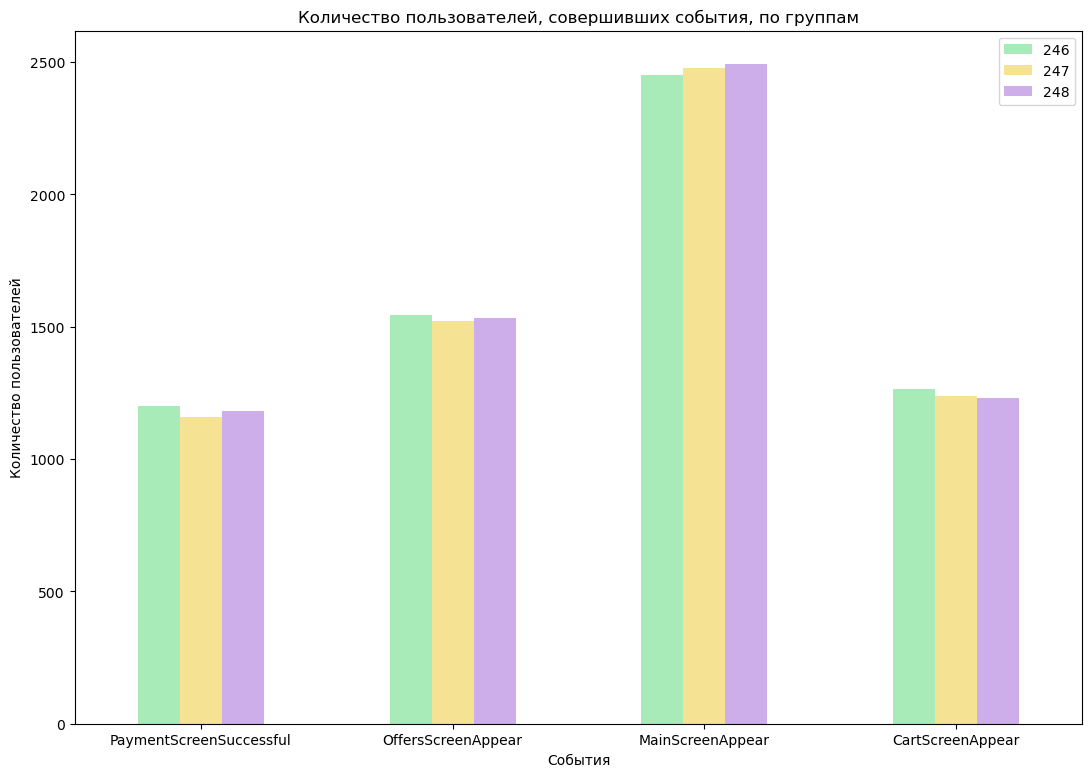

In [41]:
# визуализируем
plt.rcParams['figure.figsize'] = [13, 9]
group_event.plot(kind='bar', color=['#A8EBB8', '#F5E292', '#CDAEEB'])
plt.legend()
plt.title('Количество пользователей, совершивших события, по группам')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=0);

Каждое событие в воронке совершали разное количество пользователей из контрольных и эксперементальной групп. Проверим, есть ли разница между контрольными группами  246 и 247. Мы проверяем гипотезу о равенстве долей на каждом шаге воронки.  
Нулевая гипотеза: группы равны.  
Альтернативная гипотеза: между группами есть значимая разница.

In [42]:
# таблица с группами, событиями, общим количеством пользователей
funnel_group = (filtered_data.groupby(['event_name', 'group']).agg({'device_id': 'nunique'}).reset_index().
          rename(columns={'device_id' : 'total_users'}).
          sort_values(by=['group','total_users'], ascending=False))

funnel_group = funnel_group[funnel_group['event_name'] != 'Tutorial']
funnel_group

,event_name,group,total_users
5,MainScreenAppear,248,2493
8,OffersScreenAppear,248,1531
2,CartScreenAppear,248,1230
11,PaymentScreenSuccessful,248,1181
4,MainScreenAppear,247,2476
7,OffersScreenAppear,247,1520
1,CartScreenAppear,247,1238
10,PaymentScreenSuccessful,247,1158
3,MainScreenAppear,246,2450
6,OffersScreenAppear,246,1542


In [43]:
# задаем функцию для проверки разницы между группами

def z_test(df1, df2, event, alpha):
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['device_id'].nunique(), 
                        df2['device_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    successes = np.array([df1[df1['event_name'] == event]['device_id'].nunique(), 
                        df2[df2['event_name'] == event]['device_id'].nunique()])
    trials=np.array([df1['device_id'].nunique(), 
                        df2['device_id'].nunique()])
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    print('Событие:', event)
    print('p_value: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')
    

In [44]:
# применяем функцию
for event in funnel_group['event_name'].unique():
    z_test(filtered_data[filtered_data['group'] == 246], filtered_data[filtered_data['group'] == 247], event, 0.05)
    print()

Событие: MainScreenAppear
p_value:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
p_value:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
p_value:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
p_value:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу



По результатам теста между контрольными группами нет разницы. Далее мы проверим, есть ли разница между контрольными группами с группой с изменённым шрифтом.

In [45]:
# сравниваем экспериментальную группу 248 с контрольной 246
for event in funnel_group['event_name'].unique():
    z_test(filtered_data[filtered_data['group'] == 246], filtered_data[filtered_data['group'] == 248], event, 0.05)
    print()

Событие: MainScreenAppear
p_value:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
p_value:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
p_value:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
p_value:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу



In [46]:
# сравниваем экспериментальную группу 248 с контрольной 247
for event in funnel_group['event_name'].unique():
    z_test(filtered_data[filtered_data['group'] == 247], filtered_data[filtered_data['group'] == 248], event, 0.05)
    print()

Событие: MainScreenAppear
p_value:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
p_value:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
p_value:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
p_value:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу



In [47]:
# сравниваем экспериментальную группу 248 с объединённой контрольной группой
for event in funnel_group['event_name'].unique():
    z_test(filtered_data[filtered_data['group'] != 248], filtered_data[filtered_data['group'] == 248], event, 0.05)
    print()

Событие: MainScreenAppear
p_value:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
p_value:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
p_value:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
p_value:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу



По всем тестам между тремя группами нет разницы. Однако, так как мы проводили множественные сравнения, существует вероятность ошибки первого рода, то есть мы можем ошибочно отвергнуть нулевую гипотезу. Применим метод Шидака для уменьшения FWER.

In [48]:
# разница между группами 246 и 247
shidok_alpha = 1 - (1 - 0.05)**(1/16) # всего у нас 16 сравнений

for event in funnel_group['event_name'].unique():
    z_test(filtered_data[filtered_data['group'] == 246], filtered_data[filtered_data['group'] == 247], event, shidok_alpha)
    print()

Событие: MainScreenAppear
p_value:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
p_value:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
p_value:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
p_value:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу



In [49]:
# разница между группами 246 и 248

shidok_alpha = 1 - (1 - 0.05)**(1/16) 
for event in funnel_group['event_name'].unique():
    z_test(filtered_data[filtered_data['group'] == 246], filtered_data[filtered_data['group'] == 248], event, 0.05)
    print()

Событие: MainScreenAppear
p_value:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
p_value:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
p_value:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
p_value:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу



In [50]:
# разница между группами 247 и 248

shidok_alpha = 1 - (1 - 0.05)**(1/16) 

for event in funnel_group['event_name'].unique():
    z_test(filtered_data[filtered_data['group'] == 247], filtered_data[filtered_data['group'] == 248], event, 0.05)
    print()

Событие: MainScreenAppear
p_value:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
p_value:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
p_value:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
p_value:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу



In [51]:
# разница между группами 246+247 и 248

shidok_alpha = 1 - (1 - 0.05)**(1/16) 

for event in funnel_group['event_name'].unique():
    z_test(filtered_data[filtered_data['group'] != 248], filtered_data[filtered_data['group'] == 248], event, 0.05)
    print()

Событие: MainScreenAppear
p_value:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
p_value:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
p_value:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
p_value:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу



После применения метода Шидока результаты не изменились, различий действительно нет.

Мы проводили все тесты с уровнем значимости 0,05. При таком уровне вероятность ошибки первого рода выше, чем при α=0.01, а ошибки второго рода - ниже. Для нашего исследования было бы критичнее неверно принять нулевую гипотезу и сказать, что изменение шрифтов повлияло на поведение пользователей, чем случайно отвергнуть Н0 и утверждать, что изменений нет, так как в случае ошибки второго рода было бы потрачено много ресурсов на изменение внешнего вида приложения, не гарантирующее большую вовлеченность. Чтобы снизить вероятность ошибки первого рода, мы применили метод Шидака, который подтвердил, что различий между группами не обнаружено, и эксперимент можно считать успешно завершенным.

## Выводы

Мы проанализировали поведение пользователей мобильного приложения в период с 1 по 8 августа 2019. В логи вошли 7534 уникальных пользователей, которые совершили 240887 событий. Получилась следующая воронка событий: главный экран > страница с предложениями > корзина > оплата покупки. При переходе с главного экрана на следующую страницу теряется больше всего пользователей: переходят чуть меньше 62%. Далее потери уменьшаются: со страницы предложений в корзину переходят 81%, и из добавивших товар в корзину пользователей 95% совершают покупку. От первого шага (главной страницы) до последнего (покупки) всего доходят около 47% пользователей. Также мы узнали, что страница с туториалами не пользуется популярностью - ее посетили всего 11,2%  пользователей.

На следующем этапе мы исследовали результаты A/A/B-эксперимента, чтобы определить, стоит ли менять шрифт в приложении. Для этого мы сначала провели A/A-тест и убедились, что между двумя контрольными группами нет статистических различий. После этого сравнили результаты экспериментальной группы с каждой из контрольных групп в отдельности по каждому событию, то есть по каждому шагу воронки. По результатам Z-теста различий между тремя группами обнаружено не было. Чтобы снизить вероятность ошибки первого рода (неверно отвергнуть нулевую гипотезу об отсутствии различий), был проведен еще один тест с методом Шидака. Результаты не изменились: различий действительно нет. Таким образом, изменение шрифта не повлияло на поведение пользователей.